# Cross-correlation for magnetic data

**This notebook shows the use of the cross-correlation coefficient techniqe for magnetic data. This technique was used by several research groups$^*$ in order to estimate the magnetization direction and another signals that also depend on this vector, although not very changeable or influential by this vector.**

**The simple cross-correlation coeficient is given by:**
# $$ C = \dfrac{\sum(F - \bar{F})(G - \bar{G})}
{\sqrt{\sum(F - \bar{F})^2 \sum(G - \bar{G})^2}} $$ 
**where $F$ and $G$ represent the two magnetic data, firs derivative and horizontal gradient, for example; and $\bar{F}$ and $\bar{G}$ represent the mean for the two data sets.**

### Some researches: 
* Fedi, M., Florio, G., & Rapolla, A. (1994). A method to estimate the total magnetization direction from a distortion analysis of magnetic anomalies. Geophysical Prospecting, 42(3), 261-274. Doi: [10.1111/j.1365-2478.1994.tb00209.x/abstract](http://onlinelibrary.wiley.com/doi/10.1111/j.1365-2478.1994.tb00209.x/abstract)

* Dannemiller, N., & Li, Y. (2006). A new method for determination of magnetization direction. Geophysics, 71(6), L69-L73. Doi: [10.1190/1.2356116](http://library.seg.org/Doi/10.1190/1.2356116)

* Gerovska, D., Araúzo‐Bravo, M. J., & Stavrev, P. (2009). Estimating the magnetization direction of sources from southeast Bulgaria through correlation between reduced‐to‐the‐pole and total magnitude anomalies. Geophysical Prospecting, 57(4), 491-505. Doi: [10.1111/j.1365-2478.2008.00761.x](http://onlinelibrary.wiley.com/doi/10.1111/j.1365-2478.2008.00761.x/full)

In [1]:
# Importing all usefull libraries for this notebook
import numpy as np
import gravmag as gmc
import datafiltering as df
import matplotlib.pyplot as plt

In [2]:
def cccoef(data1, data2):
    
    '''
    Returns the crosscorrelation coefficient between two data sets, 
    which can or a single 1D array or a N-dimensional data set. It 
    is important that both data sets have the same dimension.
    
    Inputs:
    data1 - numpy array - first dataset
    data2 - numpy array - second dataset
    
    Output:
    res - scalar - cross correlation coefficient
    '''
    
    # Stablish some conditions
    assert data1.shape[0] == data2.shape[1], 'Both dataset must have the same dimension!'
    assert data1.size == data2.size, 'Both dataset must have the same number of elements!'
    
    # Calculate the simple mean
    # For the first dataset
    mean1 = data1.mean()
    # For the second dataset
    mean2 = data2.mean()
       
    # Formulation
    numerator = np.sum((data1 - mean1)*(data2 - mean2))
    den1 = np.sum((data1 - mean1)**2)
    den2 = np.sum((data2 - mean2)**2)
    res = numerator/np.sqrt(den1*den2)
    
    return res

### Simple example for the cross correlation coeffiecient

In [3]:
# Defines number of points
num = 200
# Define the three vectors along all directions
x = np.linspace(-1000, 1000, num)
y = x
z = -10.
# Creates the grid
X, Y = np.meshgrid(x, y)

In [4]:
# Define the elements of the prims for gravity and magnetic computation
modelgrav = (-400., 400., -400., 400., 100., 500., 2300)
modelmag = (-400., 400., -400., 400., 100., 500., 2.300)

### Computing: (i) gravity anomaly; (ii) total field anomaly; (iii) total field anomaly in magnetic pole; and (iv) reduction to pole.

In [5]:
# Computes the potential data
gz = gmc.prism_gz(X, Y, z, modelgrav)
tf = gmc.prism_tf(X, Y, z, modelmag, (35., 22.), (66., 30))
tf_pole = gmc.prism_tf(X, Y, z, modelmag, (90., 0.), (90., 0.))

In [10]:
# Compute the true reduction to pole by using Fourier domain
rtp_calc = df.reduction(X, Y, tf, (66., 30.), (35., 22.), (90., 0.), (90., 0.))

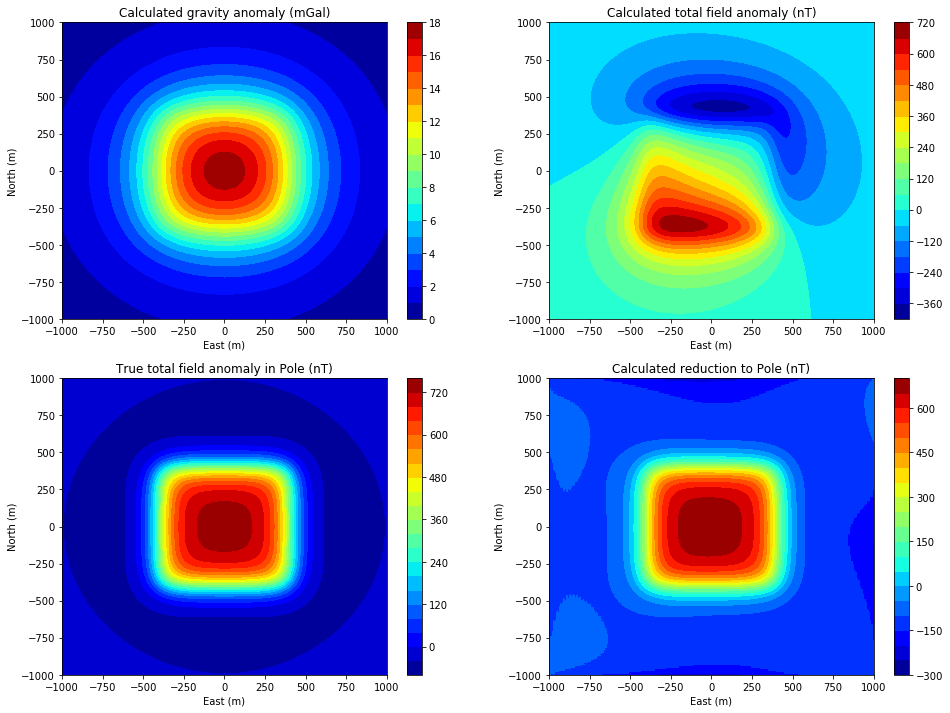

In [11]:
# Plotting the result
plt.close('all')
plt.figure(figsize=(16, 12))

plt.subplot(2, 2, 1)
plt.contourf(X, Y, gz, 20, cmap = plt.cm.jet)
plt.title('Calculated gravity anomaly (mGal)')
plt.xlabel('East (m)')
plt.ylabel('North (m)')
plt.colorbar()

plt.subplot(2, 2, 2)
plt.contourf(Y, X, tf, 20, cmap = plt.cm.jet)
plt.title('Calculated total field anomaly (nT)')
plt.xlabel('East (m)')
plt.ylabel('North (m)')
plt.colorbar()

plt.subplot(2, 2, 3)
plt.contourf(Y, X, tf_pole, 20, cmap = plt.cm.jet)
plt.title('True total field anomaly in Pole (nT)')
plt.xlabel('East (m)')
plt.ylabel('North (m)')
plt.colorbar()

plt.subplot(2, 2, 4)
plt.contourf(Y, X, rtp_calc, 20, cmap = plt.cm.jet)
plt.title('Calculated reduction to Pole (nT)')
plt.xlabel('East (m)')
plt.ylabel('North (m)')
plt.colorbar()

plt.show()

### Computing the correlation coefficient by using a grid for inclination and declination values

In [14]:
# Create the intervals for inclination and declination
inc = np.linspace(10., 90., 100)
dec = np.linspace(-180., 180., 150)

ni, nd = inc.size, dec.size
# Create the grid
Dec, Inc = np.meshgrid(dec, inc)

In [15]:
# Create the array to allocate the result
res1 = np.zeros([ni, nd])
res2 = np.zeros([ni, nd])
res3 = np.zeros([ni, nd])

In [16]:
# Computing all result
for j in range(nd):
    for i in range(ni):
        rtp = df.reduction(x, y, tf, (45., 30.), (inc[i], dec[j]), (90., 0.), (90., 0.))
        hga = df.totalgrad(x, y, rtp)
        tilt = df.tilt(x, y, rtp)
        dz = df.zderiv(x, y, rtp, 1)
        # Cross-correlation between reduction to pole and horizontal gradient
        res1[i,j] = cccoef(rtp, hga)
        # Cross-correlation between reduction to pole and tilt angle
        res2[i,j] = cccoef(rtp, tilt)
        # Cross-correlation between reduction to pole and vertical gradient
        res3[i,j] = cccoef(rtp, dz)

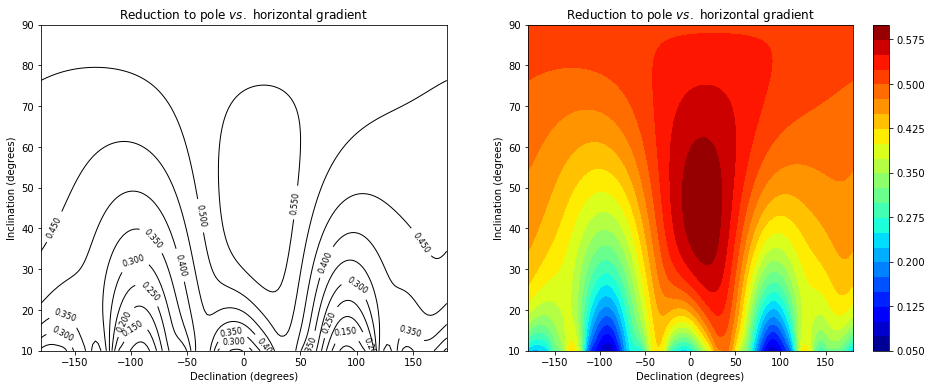

In [60]:
# Plotting the first result
plt.close('all')
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plot1 = plt.contour(Dec, Inc, res1, 10, colors = 'k', linestyle = 'solid', linewidths = 1)
plt.clabel(plot1, fontsize=8)
plt.rcParams['contour.negative_linestyle'] = 'solid'
plt.title('Reduction to pole $vs.$ horizontal gradient')
plt.xlabel('Declination (degrees)')
plt.ylabel('Inclination (degrees)')

plt.subplot(1, 2, 2)
plt.contourf(Dec, Inc, res1, 20, cmap = plt.cm.jet)
plt.title('Reduction to pole $vs.$ horizontal gradient')
plt.xlabel('Declination (degrees)')
plt.ylabel('Inclination (degrees)')
plt.colorbar()

plt.show()

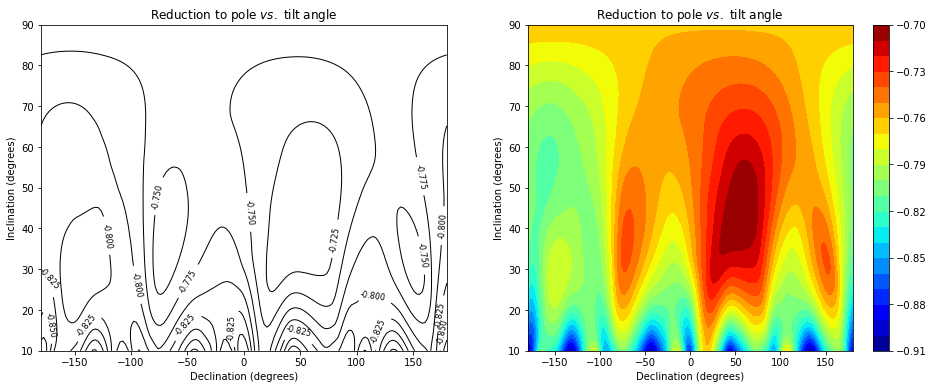

In [61]:
# Plotting the second result
plt.close('all')
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plot2 = plt.contour(Dec, Inc, res2, 8, colors = 'k', linestyle = 'solid', linewidths = 1)
plt.clabel(plot2, fontsize=8)
plt.rcParams['contour.negative_linestyle'] = 'solid'
plt.title('Reduction to pole $vs.$ tilt angle')
plt.xlabel('Declination (degrees)')
plt.ylabel('Inclination (degrees)')

plt.subplot(1, 2, 2)
plt.contourf(Dec, Inc, res2, 20, cmap = plt.cm.jet)
plt.title('Reduction to pole $vs.$ tilt angle')
plt.xlabel('Declination (degrees)')
plt.ylabel('Inclination (degrees)')
plt.colorbar()

plt.show()

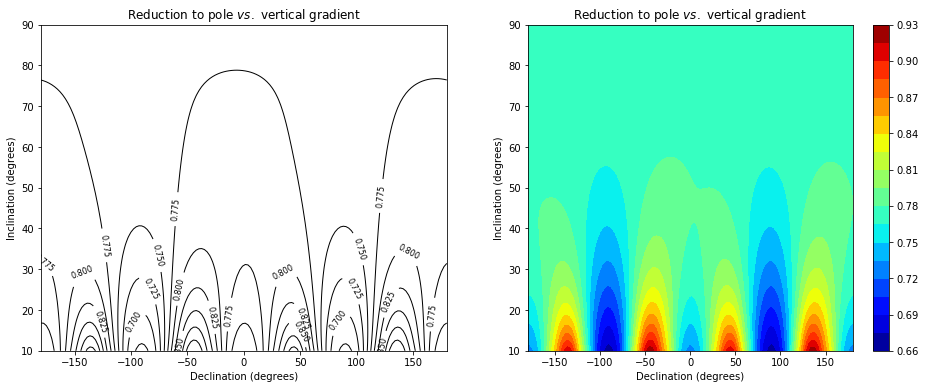

In [58]:
# Plotting the third result
plt.close('all')
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plot3 = plt.contour(Dec, Inc, res3, 10, colors = 'k', linestyle = 'solid', linewidths = 1)
plt.clabel(plot3, fontsize=8)
plt.rcParams['contour.negative_linestyle'] = 'solid'
plt.title('Reduction to pole $vs.$ vertical gradient')
plt.xlabel('Declination (degrees)')
plt.ylabel('Inclination (degrees)')

plt.subplot(1, 2, 2)
plt.contourf(Dec, Inc, res3, 20, cmap = plt.cm.jet)
plt.title('Reduction to pole $vs.$ vertical gradient')
plt.xlabel('Declination (degrees)')
plt.ylabel('Inclination (degrees)')
plt.colorbar()

plt.show()